# Actions Matter - US Covid-19 Infection Trends

Analysis of daily Covid-19 confirmed cases shows how powerfully the mitigation measures put in place in the US between 3/19/20 and 4/7/20 were working to contain the spread of the virus, but also how the various pressure to avoid those measures, indicated by vocal resistance of a small minority, amplified by the White House, Fox News and the like after 4/10/20 is already threatening to bring about a second outbreak, cause immense unecessary suffering and loss of life.

**[Jump right to the bottom line](#bottomline)**

*Note: I assembled this notebook on Sunday 4/19, hoping thast the drop in new cases that day meant that the trend we had seen all week was just expected fluctuation. Monday's positive report offered some confirmation, but Tuesday 4/21 both of those appeared more likely to be just under-reporting.*

We use a simple empirical model here, since the penatration of Covid-19 in the population is still such a small fraction that the slowing that arises in SIR models due to increasing immunity is negligable. 


This notebook utilizes [data kindly made available](https://github.com/CSSEGISandData/COVID-19) by the [Johns Hopkins University Center for Systems Science and Engineering (JHU CSSE)](https://systems.jhu.edu/) at and used for their 
[Visual Dashboad](https://www.arcgis.com/apps/opsdashboard/index.html#/bda7594740fd40299423467b48e9ecf6).  It provides a temporal perspective that complements their excellent geospatial presentation.  

* Repo for this and other notebnooks at: [https://github.com/deculler/covid19](https://github.com/deculler/covid19)
* Website for this repo: [https://deculler.github.io/covid19/](https://deculler.github.io/covid19/)

## View and run the notebooks

* [View the notebook with nbviewer](https://nbviewer.jupyter.org/github/deculler/covid19/blob/master/Covid19-US-Actions-Matter.ipynb)
* [Launch it on mybinder.org](https://mybinder.org/v2/gh/deculler/covid19/master?filepath=work/Covid19-US-Actions-Matter.ipynb)
* [@UCB on datahub.berkeley.edu](http://datahub.berkeley.edu/user-redirect/interact?account=deculler&repo=covid19&branch=master&path=Covid19-US-Actions-Matter.ipynb)
  

In [1]:
# HIDDEN
# This useful nonsense should just go at the top of your notebook.
from datascience import *
%matplotlib inline
#%matplotlib notebook
import matplotlib.pyplot as plots
import numpy as np
import scipy
plots.style.use('fivethirtyeight')
plots.rc('lines', linewidth=2, color='r')
from ipywidgets import interact
import ipywidgets as widgets
# datascience version number of last run of this notebook
version.__version__

'0.15.0'

In [2]:
import sys
if not '.' in sys.path:
    sys.path.append(".")

# Timeseries derivative of the Tables Datafram module
from timetable import TimeTable

# Tools used throughout the notebook
from covid import *

In [3]:
# Preprocssing and Cleaning

def by_state_cases(raw_region):
    """Aggregate state level data from the raw source"""
    res = raw_region.drop(['Province/State', 'Lat','Long']).group('Country/Region', sum)
    
    for lbl in res.labels[1:] :
        res.relabel(lbl, format_day(lbl[:-4]))
    return res

def by_state_deaths(raw_region):
    """Aggregate state level data from the raw source"""
    res = raw_region.drop(['Province/State', 'Lat','Long']).group('Country/Region', sum)
    
    for lbl in res.labels[1:] :
        res.relabel(lbl, format_day(lbl[:-4]))
    return res

def get_countries(raw_world):
    """Country level metadata from the raw source"""
    res = raw_world.select(['Country/Region', 'Lat', 'Long']).group('Country/Region', np.mean)
    for lbl in res.labels[1:] :
        res.relabel(lbl, lbl[:-5])
    return res

In [4]:
def label_val(trend, x, val):
    x_val = trend.get(x, trend.time_column)
    y_val = trend.get(x, val)
    plots.text(x_val, y_val, "{:,}".format(int(y_val)))

In [5]:
def add_lines(trend, col, ymax, ymin, lines):
    skip = (ymax - ymin) / len(lines) 
    y = ymax
    my = np.nanmin(trend[col])
    for (date, text) in lines :
        plots.text(date, y, text)
        plots.plot([date, date], [my, y], ":")
        y = y - skip

In [6]:
def proj_trend(trend, start=7, end=0, dist=14):
    last_day = trend.last(trend.time_column)
    fit_start = inc_day(last_day, -start)
    end = min(end, start)
    fit_end = inc_day(last_day, -end)
    proj_prog(trend, 'US', dist, fit_start=fit_start, fit_end=fit_end)

## Pull the Current Data

In [7]:
worldCasesURL = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv" 
raw_states_cases = Table.read_table(worldCasesURL)
cases_by_state = by_state_cases(raw_states_cases)
cases = TimeTable.transpose(cases_by_state, 'Country/Region', time_col='date', time_less = less_day, time_inc = inc_day)
countries = get_countries(raw_states_cases)
# Last day of rerported data
last_day = cases['date'][-1]
last_day, countries.num_rows

('04/23/20', 185)

## World-wide picture

Here the number of cases and the new cases per day are obtained directly from the JHU data.  

We take as a rough approximation to the number of active cases to be the sum of the new cases over the past 14 days, due to the lack of clear tracking of case resolutions.  

https://www.who.int/docs/default-source/coronaviruse/who-china-joint-mission-on-covid-19-final-report.pdf offers
"Using available preliminary data, the median time from onset to clinical recovery for mild
cases is approximately 2 weeks and is 3-6 weeks for patients with severe or critical disease."

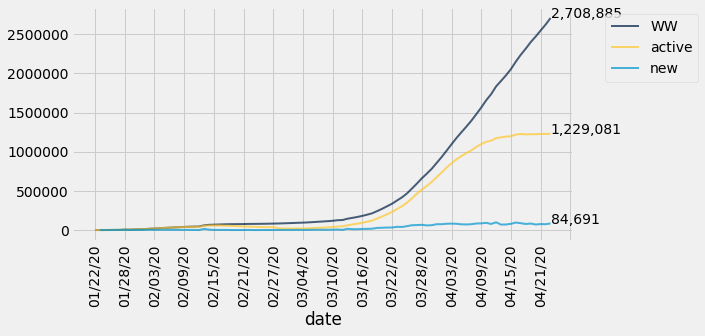

In [8]:
WW_cases = cases.select(cases.time_column)
WW_cases['WW'] = cases.sum_cols()
WW_case_trend = WW_cases.trend()
WW_case_trend.extract(['WW', 'active', 'new']).oplot(width=8, xlab=20)
label_val(WW_case_trend, last_day, 'WW')
label_val(WW_case_trend, last_day, 'active')
label_val(WW_case_trend, last_day, 'new')

## The US picture

Here is the same picture for the United States, calling out the current reported number of total casees to date, the number of new cases in the most recent report and our simple estimate of "active" cases, i.e., those confirmed in the previous 14 days.

In [9]:
US_cases = cases.extract('US')
US_trend = US_cases.trend()

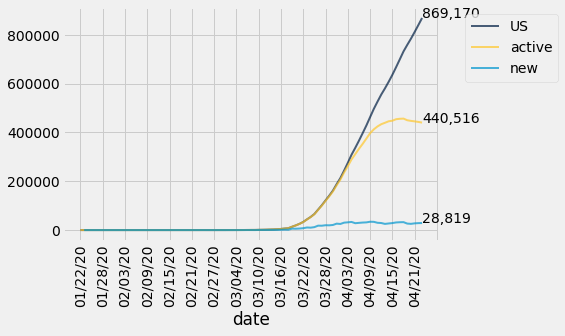

In [10]:
US_trend.extract(['US', 'active', 'new']).oplot(xlab=20)
label_val(US_trend, last_day, 'US')
label_val(US_trend, last_day, 'active')
label_val(US_trend, last_day, 'new')

## From counts to rates

The daily dynamics in the spread of the disease get easily lost in the sheer scale of the exponential growth.  We can see the critical pattern across a wide range of scale by looking instead at the daily rate of growrth.
 
The *arate* is simply the number of new cases each divided by the estimated number of active cases at that time. 

Plotting this we see scattered early reports throughout the first month of global spread. In late February we see it
rising to 30% per day.  At this rate the number of cases grow 100-fold in weeks.

We can also see the decaying trend following declarations of national emergency in mid March, with shelter-in-place restrictions growing from 3/19/20 onward.

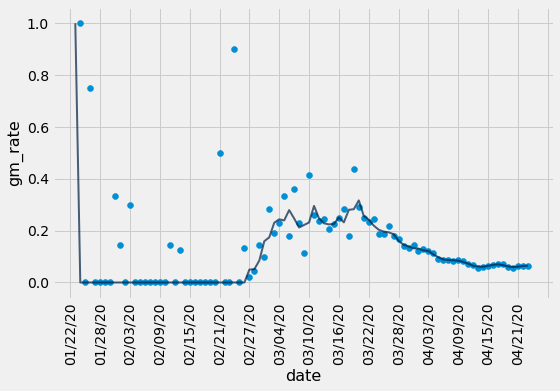

In [11]:
plot_rate_trend(US_trend, 'arate')

## The US growth phase

Focusing in on the period from March 1 on, following graph shows what the national picture to where we are today. The same period is shown with just the new cases, showing clearly the growth phase and the impact of mitigation measures,

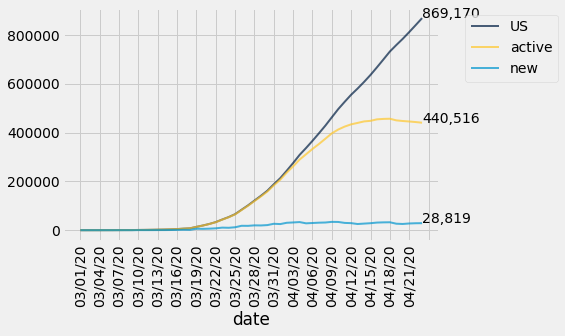

In [12]:
US_trend.extract(['US', 'active', 'new']).after('03/01/20').oplot(xlab=20)
label_val(US_trend, last_day, 'US')
label_val(US_trend, last_day, 'active')
label_val(US_trend, last_day, 'new')

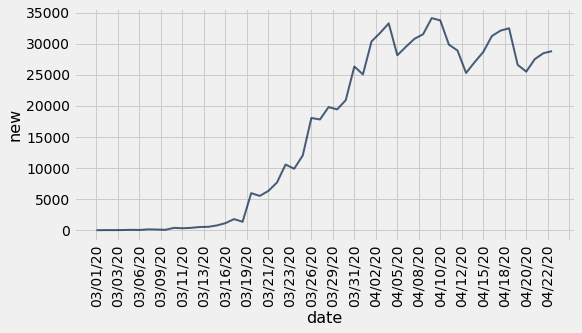

In [13]:
US_trend.extract('new').after('03/01/20').oplot(width=8, xlab=25)

# Putting mitigation measures in place

But this picture revealed itself over time, and leaders were forced to make painful, critical decisions based on what was observed at the time and projections of what was ahead.  Here is the number of cases and the estimate of active ones a the point where Governors began to act.

Note that with the growth from small numbers to nearly 20,000 occuring in just two weeks, the difference in total and active is incidental.

https://www.nytimes.com/interactive/2020/us/coronavirus-stay-at-home-order.html

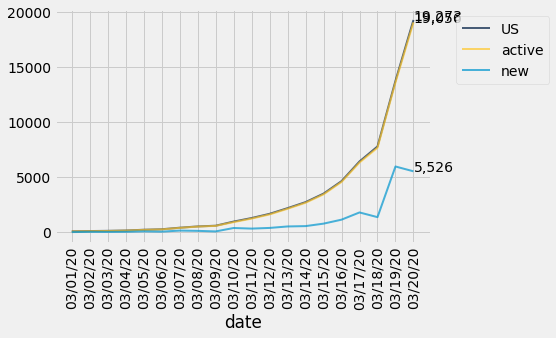

In [14]:
US_trend.between('03/01/20', '03/20/20').extract(['US', 'active', 'new']).oplot(xlab=20)
label_val(US_trend, '03/20/20', 'US')
label_val(US_trend, '03/20/20', 'active')
label_val(US_trend, '03/20/20', 'new')

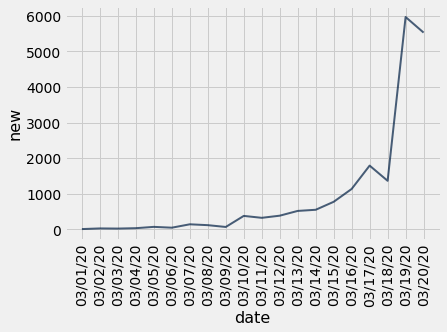

In [15]:
US_trend.between('03/01/20', '03/20/20').extract(['new']).oplot()

The daily rate is bouncing around with variability in reporting, but it is huge - *25 to 40 % per day* and trending upward.  This means that not only is the spread growing expoentially, but the rate of spread is increasing!

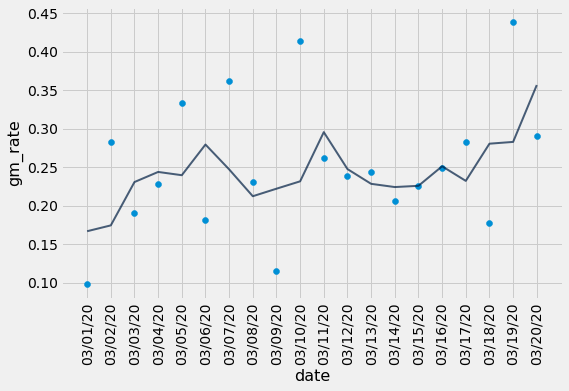

In [16]:
plot_rate_trend(US_trend.between('03/01/20', '03/20/20'), 'arate')

Although the data is noisey, we can do our best to fit a curve to it.  It is not clear whether we should be looking for a linear model or an exponential model, but in the slope is small enough that in the near frame they are hard to distinguish.

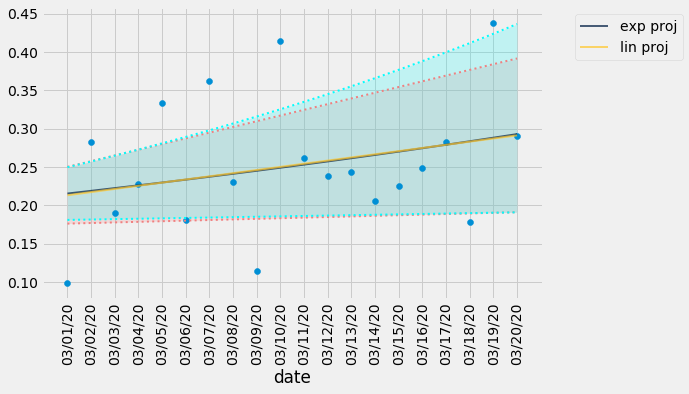

In [17]:
show_model_rate_trend(US_trend.between('03/01/20', '03/20/20'), 'arate', alpha=0.2)

## The shock on the horizon

But even at this stage, with 20,000 cases and this slight upward trend, just projecting the number of cases out two weeks would have provide an unbelievably frightening picture.  Presumably, more elaborate forms of this analysis was what work the Counties and States into action,.

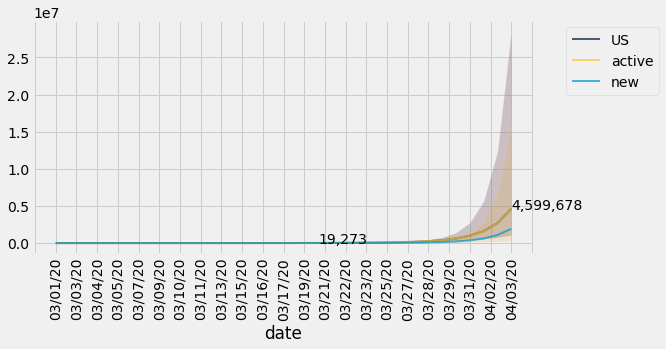

In [18]:
proj_trend(US_trend.between('03/01/20', '03/20/20'), start=7, end=0, dist=14)

## Serious Mitigation Phase

Looking the at the following three weeks of serious mitigation efforts, we still see a rapid rise in the number of active cases, from 20,000 to half a million, but even this is of an altogether different character than what we were looking at March 20.

The main point is that the rates and the growth in rates are the clearest early indicator of what's ahead.

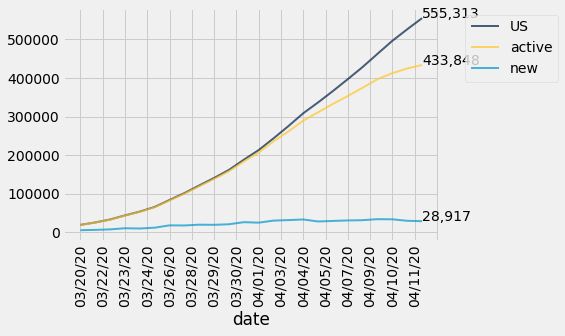

In [19]:
US_trend.between('03/20/20', '04/12/20').extract(['US', 'active', 'new']).oplot(xlab=20)
label_val(US_trend, '04/12/20', 'US')
label_val(US_trend, '04/12/20', 'active')
label_val(US_trend, '04/12/20', 'new')

### Progress step by step

Here we see the change of direction and the steady improvement in the growth rate over this period.

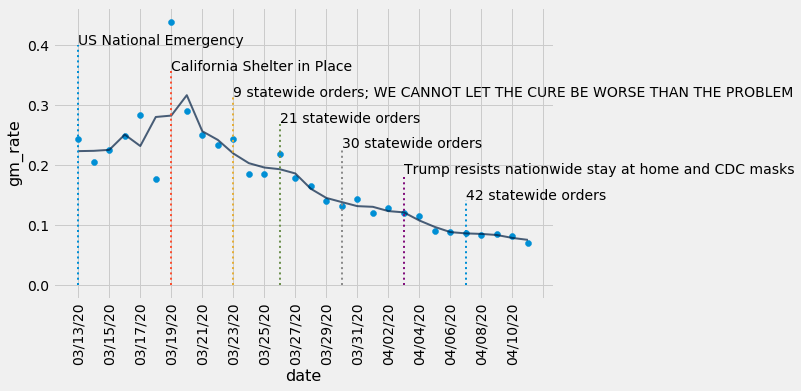

In [20]:
plot_rate_trend(US_trend.between("03/13/20", '04/11/20'), 'arate')
add_lines(US_trend, 'arate', 0.4, 0.1, [("03/13/20", "US National Emergency"),
                                        ("03/19/20", "California Shelter in Place"),
                                        ("03/23/20", "9 statewide orders; WE CANNOT LET THE CURE BE WORSE THAN THE PROBLEM"),
                                        ("03/26/20", "21 statewide orders"),
                                        ("03/30/20", "30 statewide orders"),
                                        ("04/03/20", "Trump resists nationwide stay at home and CDC masks"),
                                        ("04/07/20", "42 statewide orders")
                                       ])


Starting from a few days after measures in the hardest hit cities, followed by state-level measures, the trend is clear enough that we can feel comfortable building an empirical model of it, even though the political, social, and economic dynamics of putting it in place are extremely complex.

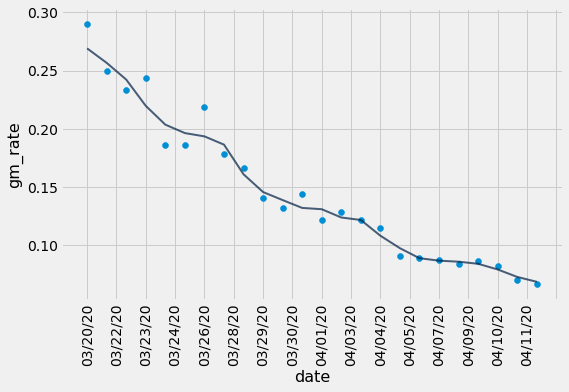

In [21]:
plot_rate_trend(US_trend.between('03/20/20', '04/12/20'), 'arate')

### A Clear Model

And here we see ther clean, dropping and leveling of a fractional exponential: 0.27 x 0.94**D

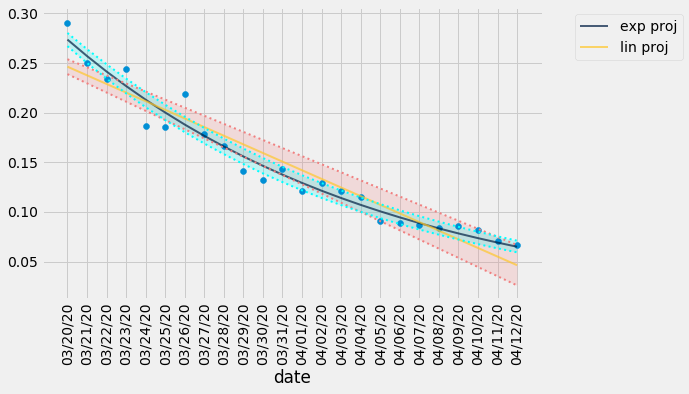

In [22]:
show_model_rate_trend(US_trend.between('03/20/20', '04/12/20'), 'arate')

Based on such a model, as Easter arrived we could project out and see "the curve of cases flattening", the number of active cases dropping, and the new cases per day reducing to manageable numbers.

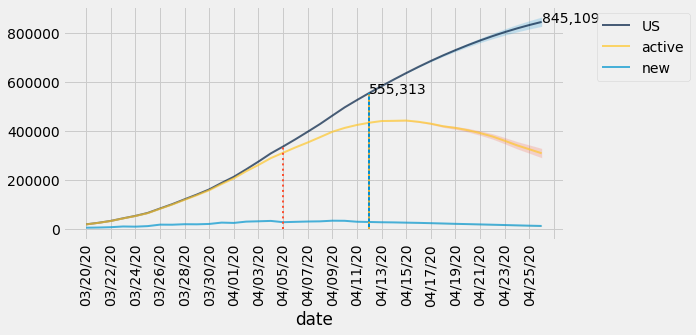

In [23]:
proj_trend(US_trend.between('03/20/20', '04/12/20'), start=7, end=0, dist=14)

In [24]:
project_progressive_trend(US_trend.between('03/20/20', '04/12/20'), 'US', 14).show()

date,US,new,active,arate,US-,US+,new-,new+,active-,active+
03/20/20,19273,5526,19056,0.289987,19273,19273,5526,5526,5526,5526
03/21/20,25600,6327,25338,0.249704,25600,25600,6327,6327,6327,6327
03/22/20,33276,7676,32874,0.233498,33276,33276,7676,7676,7676,7676
03/23/20,43843,10567,43325,0.243901,43843,43843,10567,10567,10567,10567
03/24/20,53736,9893,53153,0.186123,53736,53736,9893,9893,9893,9893
03/25/20,65778,12042,64819,0.185779,65778,65778,12042,12042,12042,12042
03/26/20,83836,18058,82555,0.218739,83836,83836,18058,18058,18058,18058
03/27/20,101657,17821,99994,0.178221,101657,101657,17821,17821,17821,17821
03/28/20,121465,19808,119286,0.166055,121465,121465,19808,19808,19808,19808
03/29/20,140909,19444,138182,0.140713,140909,140909,19444,19444,19444,19444


We might even be tempted to project out further and think about when this might begin to pass.

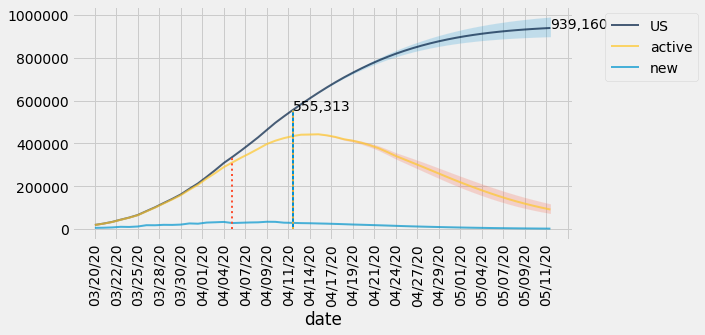

In [25]:
proj_trend(US_trend.between('03/20/20', '04/12/20'), start=7, end=0, dist=30)

If the model we saw for the week before Easter was still relevant today we would still be projecting an end in sight.

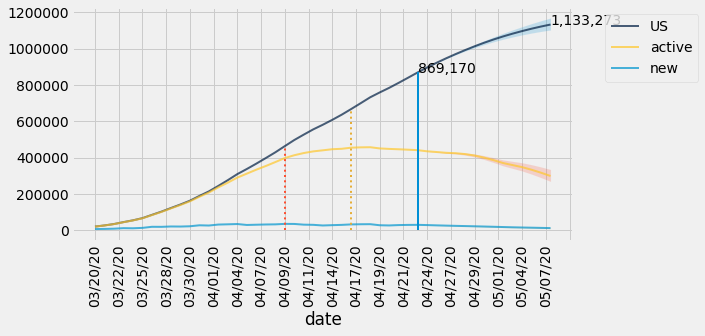

In [26]:
proj_trend(US_trend.after("03/20/20"), start=14, end=7, dist=14)

## But then the narrative changed

Starting before Easter can continuing throughout the week following, talk of easing restrictions is thrown around lightly at high levels and small minority voices pushing back on containment measures are amplified, presumably weakening the resolve to maintain difficult measures.

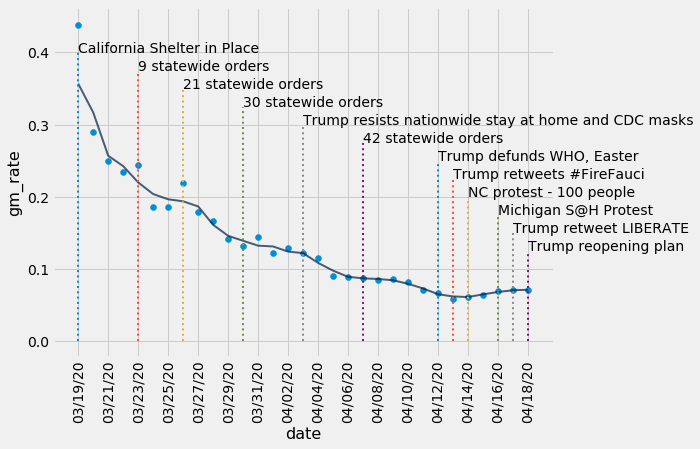

In [27]:
plot_rate_trend(US_trend.between("03/19/20", "04/18/20"), 'arate', height=6)
add_lines(US_trend, 'arate', 0.4, 0.1, [("03/19/20", "California Shelter in Place"),
                                        ("03/23/20", "9 statewide orders"),
                                        ("03/26/20", "21 statewide orders"),
                                        ("03/30/20", "30 statewide orders"),
                                        ("04/03/20", "Trump resists nationwide stay at home and CDC masks"),
                                        ("04/07/20", "42 statewide orders"),
                                        ("04/12/20", "Trump defunds WHO, Easter"),
                                        ("04/13/20",  "Trump retweets #FireFauci"),
                                        ("04/14/20",  "NC protest - 100 people"),
                                        ("04/16/20",  "Michigan S@H Protest"),
                                        ("04/17/20", "Trump retweet LIBERATE"),
                                        ("04/18/20", "Trump reopening plan")
                                       ])


## Unflattening the curve

Fitting a model to this longer period, we see clearly how the pattern of improvement disappears, starting from that point.  The week following Easter may look like small numbers, but they are qualitatively different than the weeks before.

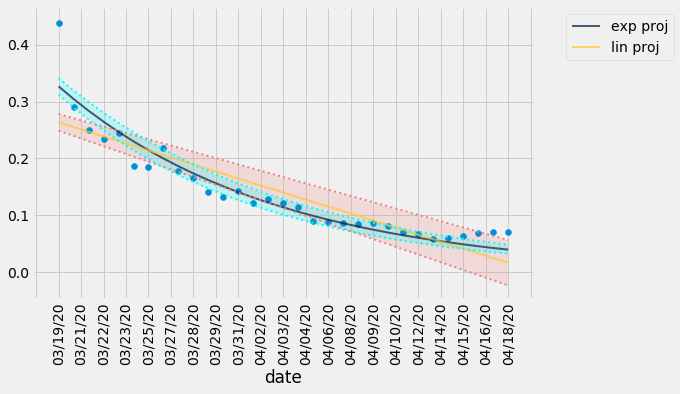

In [28]:
show_model_rate_trend(US_trend.between("03/19/20", "04/18/20"))

## The changing trend with the changing national message

Fitting the model to the week after Easter it is an all together different picture than what we saw as restrictions went into place.  We see it increasing from 6% per day to 7% over the course of the week.

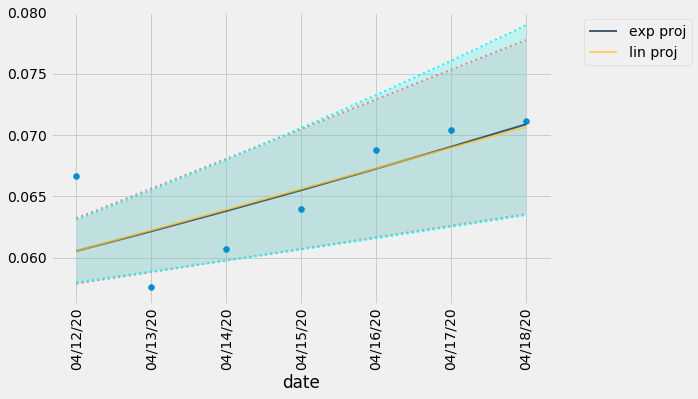

In [29]:
show_model_rate_trend(US_trend.between("04/12/20", "04/18/20"))

Looking just at the new cases, we can see cause for alarm.  

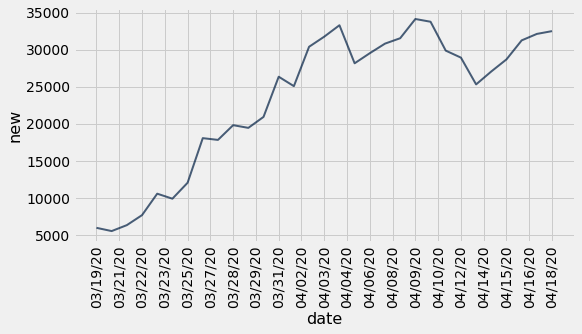

In [30]:
US_trend.extract(['new']).between("03/19/20", "04/18/20").oplot(width=8, xlab=25)

Projecting forward using the model the week up to 4/18/20, we see a very different picture than what we would have projected a week earlier.   The curve is no longer flattening, it is bending up.  And once the upward exponential kicks in, everything changes in a week.

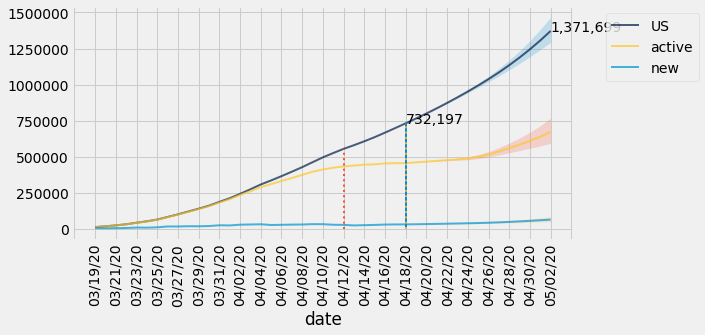

In [31]:
proj_trend(US_trend.between("03/19/20", "04/18/20"), start=6, end=0, dist=14)

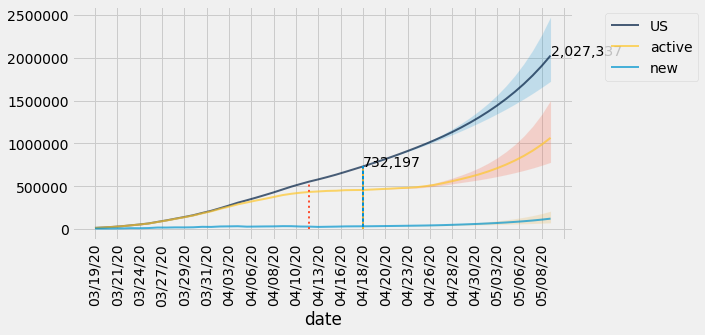

In [32]:
proj_trend(US_trend.between("03/19/20", "04/18/20"), start=6, end=0, dist=21)

## A new pattern, a new model

Taking just one day less into account, the picture is even more dire.

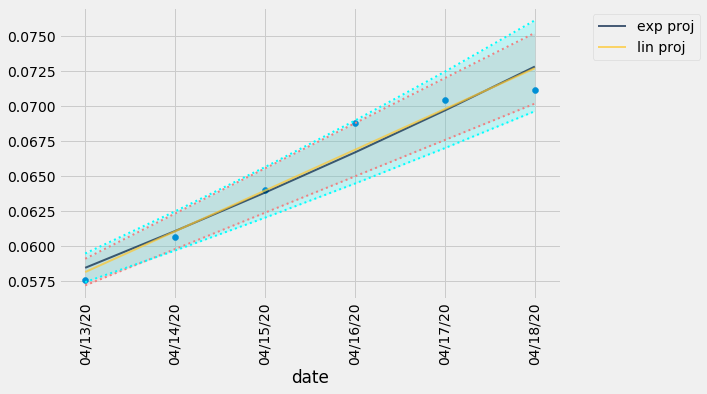

In [33]:
show_model_rate_trend(US_trend.between("04/13/20", "04/18/20"))

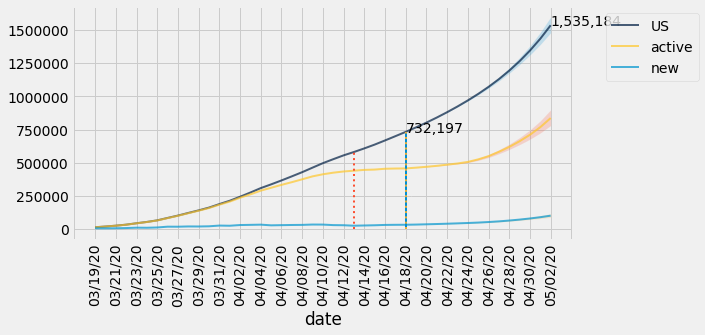

In [34]:
proj_trend(US_trend.between("03/19/20", "04/18/20"), start=5, end=0, dist=14)

## A reprieve ?

Fortunately, the next two days showed improvement.  The number of new cases declined, the model for the last week is at least flat.  This is not what we want to live with.  It means the number of new cases is essentially constant for the forseable future.  The total number of cases doesn't flatten, it just keep growing.

4/21 Update, that reprieve was indeed short-lived, perhaps due to deferred accounting of cases.  The number of new cases is up significantly.

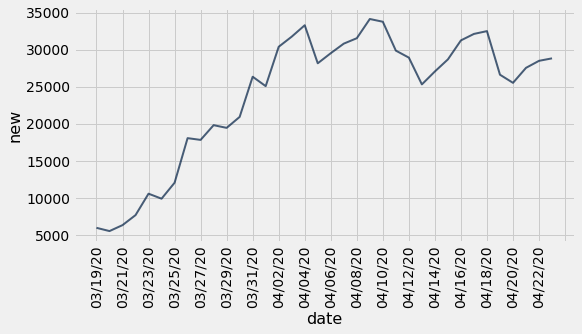

In [35]:
US_trend.extract(['new']).after("03/19/20").oplot(width=8, xlab=25)

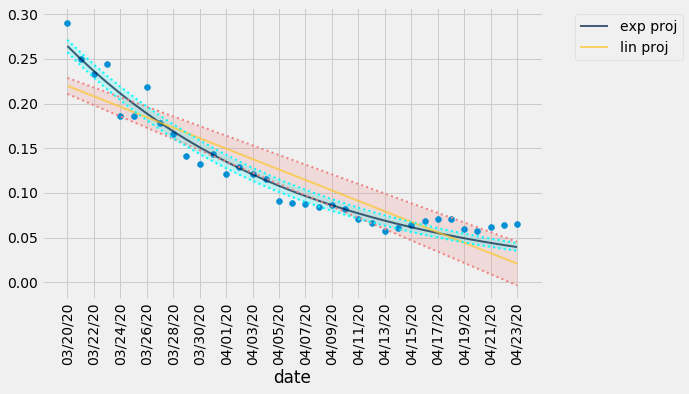

In [36]:
show_model_rate_trend(US_trend.after("03/20/20"))

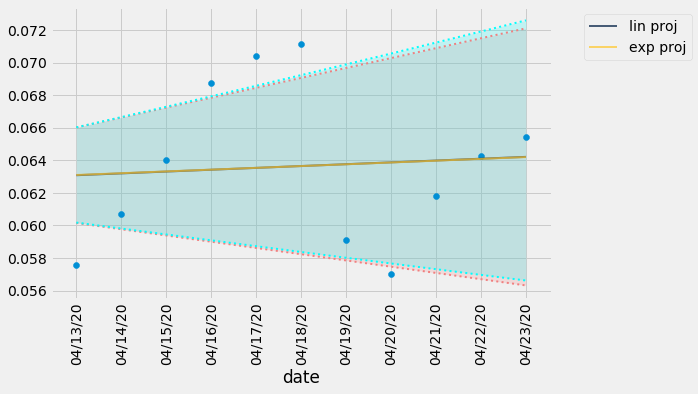

In [37]:
show_model_rate_trend(US_trend.after("04/13/20"))

04/21 update: The picture yesterday looked to be turning grim, but today's picture is much worse.

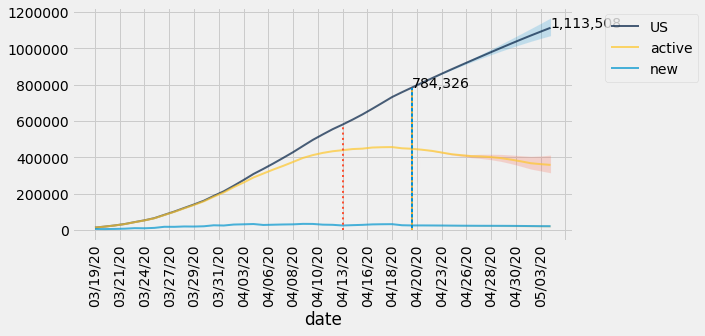

In [38]:
proj_trend(US_trend.between("03/19/20", "04/20/20"), start=7, end=0, dist=14)

Here's what we are seeing today, projecting out two weeks with the trend since Easter.

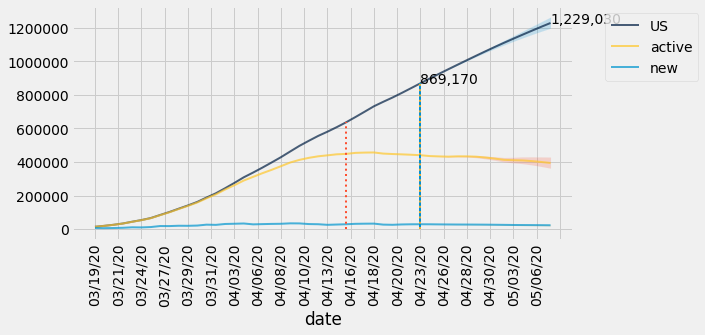

In [39]:
proj_trend(US_trend.after("03/19/20"), start=8, end=0, dist=14)

Here is what we would have projected back on Easter that we would be seeing at this point.  The worst looked over and we could contemplate reopening carefully.

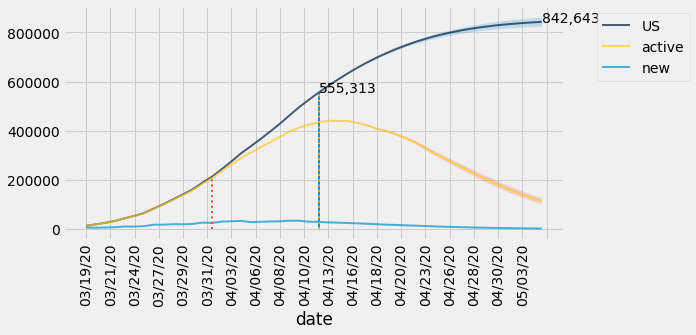

In [40]:
proj_trend(US_trend.between("03/19/20", '04/12/20'), start=11, end=0, dist=23)

## <a id="bottomline"> Bottom Line </a>
    
Putting those two pictures together we see how the rates and the change in rates offer a very clear warning signal that the next outbreak may have already started with the changes in attitude and undermining of resolve in the mitigation measures.

We have about 70,000 more cases that we projected for this day.  Out of nearly a million cases that may seem small.  But it is not, because it means the spread is going in the wrong direction.

In [41]:
prior = project_progressive_trend(US_trend.between("03/19/20", '04/12/20'), 
                          'US', 23, 
                          fit_start='04/01/20', fit_end='04/12/20')

cur = project_progressive_trend(US_trend.between("03/19/20", '04/21/20'), 'US', 14, 
                          fit_start='04/13/20', fit_end='04/21/20')

comb = prior.join('date', cur)
comb.relabel('US', 'US 4/12 proj')
comb.relabel('US_2', 'US 4/21 proj')
comb.relabel('active', 'active 4/12 proj')
comb.relabel('active_2', 'active 4/21 proj')
comb.relabel('new', 'new 4/12 proj')
comb.relabel('new_2', 'new 4/21 proj')

def show_comb(root) :
    pname = root + " 4/12 proj"
    cname = root + " 4/21 proj"
    comb.extract([pname, cname]).oplot(xlab=20)
    plots.plot(["04/12/20", "04/12/20"], [0, comb.get("04/12/20", pname)])
    plots.plot(["04/21/20", "04/21/20"], [0, comb.get("04/21/20", cname)])
    end = comb.last('date')
    plots.text(end, comb.last(pname), "{:,}".format(int(comb.last(pname))))
    plots.text(end, comb.last(cname), "{:,}".format(int(comb.last(cname))))           

In [42]:
comb.where('date', '04/21/20')

date,US 4/12 proj,new 4/12 proj,active 4/12 proj,arate,US-,US+,new-,new+,active-,active+,US 4/21 proj,new 4/21 proj,active 4/21 proj,arate_2,US-_2,US+_2,new-_2,new+_2,active-_2,active+_2
04/21/20,747698,15184.6,370021,0.0393751,741631,754018,14169.1,16272.1,363954,376341,811865,27539,445548,0.0618093,811865,811865,27539,27539,27539,27539


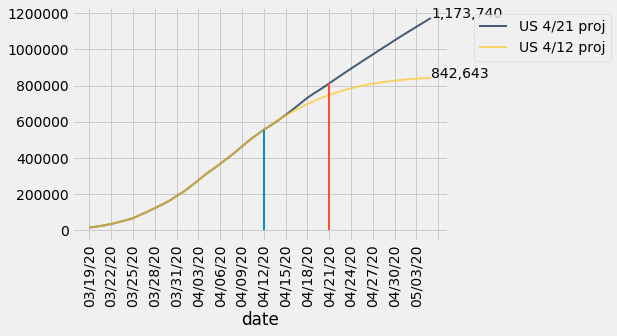

In [43]:
# Total Cases
show_comb('US')  

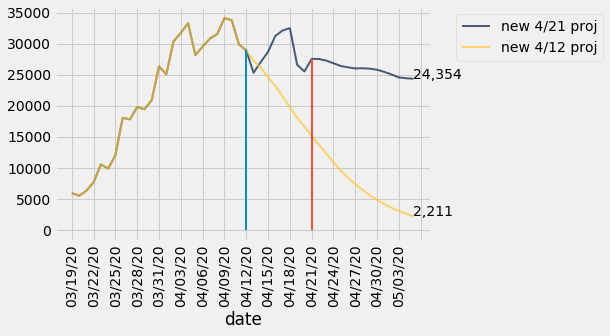

In [44]:
# NEW Cases
show_comb('new')

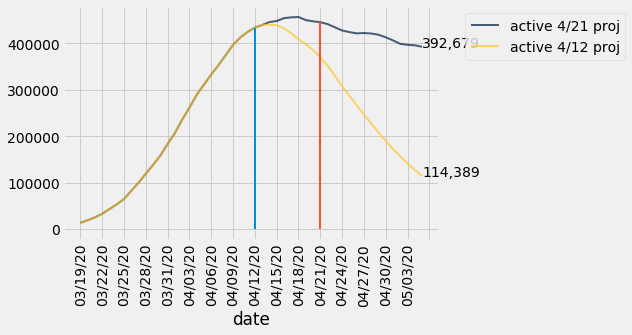

In [45]:
# Estimate of Active Cases
show_comb('active')

The bottom line is clear.  The measures we have been taking to curb the spread cannot be relaxed yet.  Playing fast and loose with the restrictions - and playing politics with civic cooperation - is playing with fire, or rather playing with lives.  It all hangs in the balance.

We need to be vigilant.  A day or two will not signal that the danger has passed, but it can very well tell us that our resolve is slipping.  It doesn't show for several days, so when the danger signals rise there is likely to be more to come.

## Feel free to explore

If you are running the live notebook you can explore with the assumptions.  
* `start` - is how long ago the model building range begins
* `end` - is how long ago it ends, so `start` > `end`
* `dist` - is how far from now to project

In [46]:
def proj_recent(start=7, end=0, dist=21):
    proj_trend(US_trend.after("03/20/20"), start=start, end=end, dist=dist)

In [47]:
_ = interact(proj_recent, start=(5, 21, 1), end=(0, 14, 1), dist=(7, 60, 1))

interactive(children=(IntSlider(value=7, description='start', max=21, min=5), IntSlider(value=0, description='…